In [23]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [24]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [25]:
PATH = "data/road-damage/"
sz=299
bs=64
arch = resnet50

In [26]:
label_csv=f'{PATH}labels.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

In [27]:
!ls {PATH}

labels.csv  models  test  tmp  train


In [28]:
label_df = pd.read_csv(label_csv)
label_df.head()

,id,damage
0,train_Adachi_00001,D44
1,train_Adachi_00002,D01
2,train_Adachi_00003,D01
3,train_Adachi_00004,D01
4,train_Adachi_00005,D00


In [29]:
label_df.pivot_table(index='damage', aggfunc=len).sort_values('id', ascending=False)

,id
damage,
D01,1793
D44,1788
D20,1327
D00,1018
D43,487
D10,299
D11,286
D40,233


In [30]:
tfms = tfms_from_model(arch, sz, aug_tfms = transforms_side_on, max_zoom = 1.5)
data = ImageClassifierData.from_csv(PATH, 'train',f'{PATH}labels.csv', test_name = 'test', 
                                   val_idxs=val_idxs, suffix='.jpg', tfms = tfms, bs = bs)


In [31]:
fn = PATH+data.trn_ds.fnames[0]
fn

'data/road-damage/train/train_Adachi_00002.jpg'

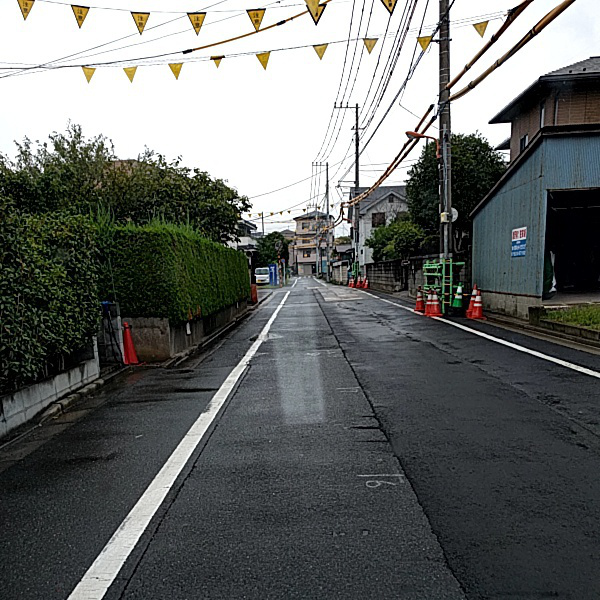

In [32]:
img = PIL.Image.open(fn);img

In [33]:
size_d = {k: PIL.Image.open(PATH+k).size for k in data.trn_ds.fnames}

In [34]:
row_sz, col_sz = list(zip(*size_d.values()))

In [35]:
row_sz = np.array(row_sz);col_sz = np.array(col_sz)

(array([   0.,    0.,    0.,    0.,    0., 5785.,    0.,    0.,    0.,    0.]),
 array([599.5, 599.6, 599.7, 599.8, 599.9, 600. , 600.1, 600.2, 600.3, 600.4, 600.5]),
 <a list of 10 Patch objects>)

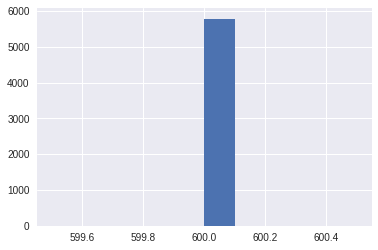

In [36]:
plt.hist(row_sz)

In [37]:
def get_data(sz,bs):
    tfms = tfms_from_model(arch, sz, aug_tfms = transforms_side_on, max_zoom = 1.5)
    data = ImageClassifierData.from_csv(PATH, 'train',f'{PATH}labels.csv', test_name = 'test', num_workers=4,
                                   val_idxs=val_idxs, suffix='.jpg', tfms = tfms, bs = bs)
    return data if sz>300 else data.resize(340,'tmp')

In [38]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

100%|██████████| 29/29 [00:38<00:00,  1.33s/it]


In [40]:
learn.fit(0.01,5)

epoch      trn_loss   val_loss   accuracy                 
    0      1.74175    1.452699   0.476487  
    1      1.484502   1.442396   0.47787                  
    2      1.362542   1.455849   0.47787                  
    3      1.26602    1.445475   0.472337                 
    4      1.17528    1.45434    0.480636                 



[array([1.45434]), 0.480636237815208]

In [41]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [42]:
lrf=learn.lr_find()

 89%|████████▉ | 81/91 [00:01<00:00, 41.07it/s, loss=4.29]


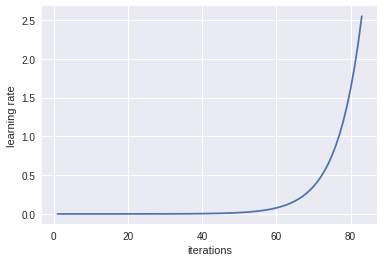

In [43]:
learn.sched.plot_lr()

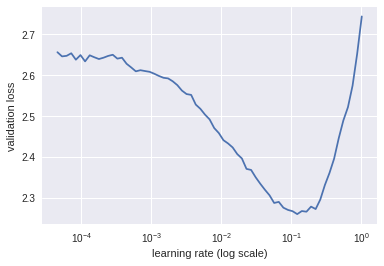

In [44]:
learn.sched.plot()

In [45]:
learn.fit(0.01,5)

epoch      trn_loss   val_loss   accuracy                 
    0      1.774817   1.50931    0.440526  
    1      1.562631   1.475582   0.471646                 
    2      1.415847   1.501138   0.439834                 
    3      1.326415   1.502511   0.460581                 
    4      1.234062   1.52687    0.470954                 



[array([1.52687]), 0.4709543573411174]

In [46]:
learn.fit(0.01,3)

epoch      trn_loss   val_loss   accuracy                  
    0      1.021897   1.516875   0.472337  
    1      0.948211   1.51739    0.484786                  
    2      0.895256   1.541683   0.470263                  



[array([1.54168]), 0.47026279432644985]

In [47]:
learn.precompute = False

In [48]:
learn.fit(0.01,5, cycle_len = 1)

epoch      trn_loss   val_loss   accuracy                 
    0      1.420814   1.4487     0.472337  
    1      1.367504   1.424152   0.479253                 
    2      1.356937   1.401127   0.478562                 
    3      1.332531   1.386161   0.501383                 
    4      1.307422   1.390915   0.487552                 



[array([1.39091]), 0.4875518671374763]

In [49]:
learn.unfreeze()

In [50]:
lr_rate = 0.01

In [51]:
lr=np.array([lr_rate/6,lr_rate/3,lr_rate])

In [52]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                 
    0      1.416926   1.281645   0.560858  
    1      1.276552   1.189014   0.598893                 
    2      1.103698   1.149468   0.61065                  
    3      1.107638   1.167215   0.598893                 
    4      0.992899   1.160409   0.612725                  
    5      0.852091   1.132254   0.615491                  
    6      0.781523   1.129019   0.618257                  



[array([1.12902]), 0.6182572617405513]

In [53]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [54]:
accuracy_np(probs, y)

0.6217150760719226

In [55]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

In [56]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[ 90  31   4   1  24   2   3  46]
 [ 19 257   2   8  14   3   8  68]
 [  9  14   9   3   8   1   0   8]
 [  7  29   3   2   7   1   3   7]
 [ 13  13   2   0 192   8   1  38]
 [  2   7   0   0  12  13   2   3]
 [  0   5   0   0   4   0  80  10]
 [ 23  42   2   2  13   4   8 256]]


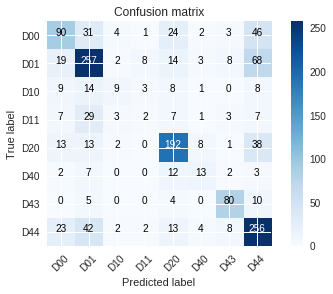

In [57]:
plot_confusion_matrix(cm, data.classes)